In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [2]:
training_vars = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']
filename = './MLP_classifier.model'

sample_all_jets_path = '../../../samples/sample_allpt_all_jets.pkl'

sample_path = '../../../samples/sample_allpt_all_jets.pkl'
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]
layers = (5, 5, 4)


This notebook explore MLP on 4 features. 

In [3]:
#FIXME No physics weights implemented in the MLP clf. 

In [4]:
sample = pd.read_pickle(sample_path)

In [5]:
print(sample.head())

       jet_pt   jet_eta  jet_nTracks  jet_trackWidth  jet_trackC1  \
0  766.747925  1.298662          2.0        0.318292     0.215923   
0  680.507996  0.447689         24.0        0.064352     0.208339   
1  619.839111  0.588775         34.0        0.115656     0.298206   
2  721.692932 -0.716669         12.0        0.049718     0.220595   
3  697.332947 -1.042831         22.0        0.091199     0.278667   

   jet_trackBDT  jet_PartonTruthLabelID  equal_weight  event_weight  \
0     -0.192873                    21.0           1.0     17.609434   
0      0.066904                     2.0           1.0      0.331535   
1      0.232268                    21.0           1.0      0.331535   
2     -0.169604                     2.0           1.0      0.377624   
3      0.029374                    21.0           1.0      0.377624   

   flatpt_weight  is_forward  pt_idx  target  
0   2.703190e-05         1.0       1     1.0  
0   2.858433e-07         0.0       1     0.0  
1   1.655248e-07 

In [6]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev,y_test = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [7]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [8]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(X_dev[training_vars])  
X_dev[training_vars] = scaler.transform(X_dev[training_vars])  
X_test[training_vars] = scaler.transform(X_test[training_vars])  

In [9]:
clf = MLPClassifier(solver='adam', alpha=1e-5, 
                    hidden_layer_sizes=layers, early_stopping = True,
                    random_state=42, verbose=True)
                    
clf.fit(X_dev[training_vars].values, y_dev.values)

Iteration 1, loss = 0.52392916
Validation score: 0.735783
Iteration 2, loss = 0.52338427
Validation score: 0.735988
Iteration 3, loss = 0.52335755
Validation score: 0.736072
Iteration 4, loss = 0.52333420
Validation score: 0.736056
Iteration 5, loss = 0.52331577
Validation score: 0.736036
Iteration 6, loss = 0.52329254
Validation score: 0.736023
Iteration 7, loss = 0.52323930
Validation score: 0.736205
Iteration 8, loss = 0.52323115
Validation score: 0.736134
Iteration 9, loss = 0.52322343
Validation score: 0.735980
Iteration 10, loss = 0.52321806
Validation score: 0.736081
Iteration 11, loss = 0.52320772
Validation score: 0.735928
Iteration 12, loss = 0.52318239
Validation score: 0.736089
Iteration 13, loss = 0.52314850
Validation score: 0.735995
Iteration 14, loss = 0.52312067
Validation score: 0.736104
Iteration 15, loss = 0.52299622
Validation score: 0.735778
Iteration 16, loss = 0.52292431
Validation score: 0.735936
Iteration 17, loss = 0.52291412
Validation score: 0.735771
Iterat

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(5, 5, 4),
              random_state=42, verbose=True)

In [10]:
y_test_decisions = clf.predict_proba(X_test[training_vars].values)[:,1]

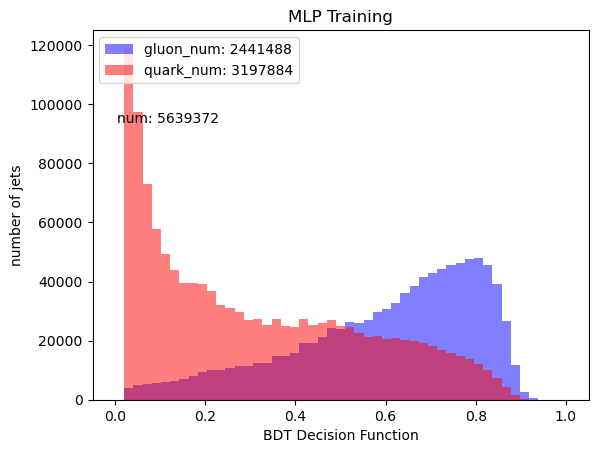

In [11]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(0, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_val.iloc[y_test_gluon_id, event_weight_idx], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_val.iloc[y_test_quark_id, event_weight_idx], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_val)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"MLP Training")
plt.savefig("MLP_Training.png")
plt.show()

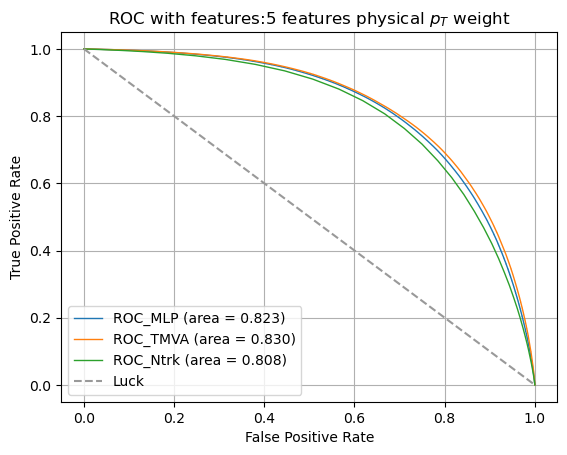

In [12]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_MLP (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC.png")
    plt.show()

Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features="5 features")


In [13]:
import pickle
pickle.dump(clf, open(filename, 'wb'))

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    

# Overtraining Validation

Text(0.5, 1.0, 'Overtraining test')

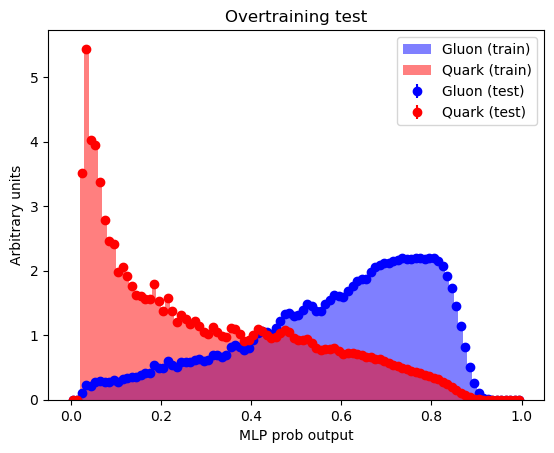

In [14]:
y_test_decisions = clf.predict_proba(X_test[training_vars].values)[:,1]
y_dev_decisions = clf.predict_proba(X_dev[training_vars].values)[:,1]


y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_dev_decisions_gluon = y_dev_decisions[np.where(y_dev==1)]
y_dev_decisions_quark = y_dev_decisions[np.where(y_dev==0)]
decisions = []
decisions.append(y_dev_decisions_gluon)
decisions.append(y_dev_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)


custom_bins = np.linspace(0, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_dev.iloc[np.where(y_dev==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_dev.iloc[np.where(y_dev==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_test.iloc[np.where(y_test==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_test.iloc[np.where(y_test==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("MLP prob output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")


# Test Extraction on Current Sample

## inclusive

### feature distribution

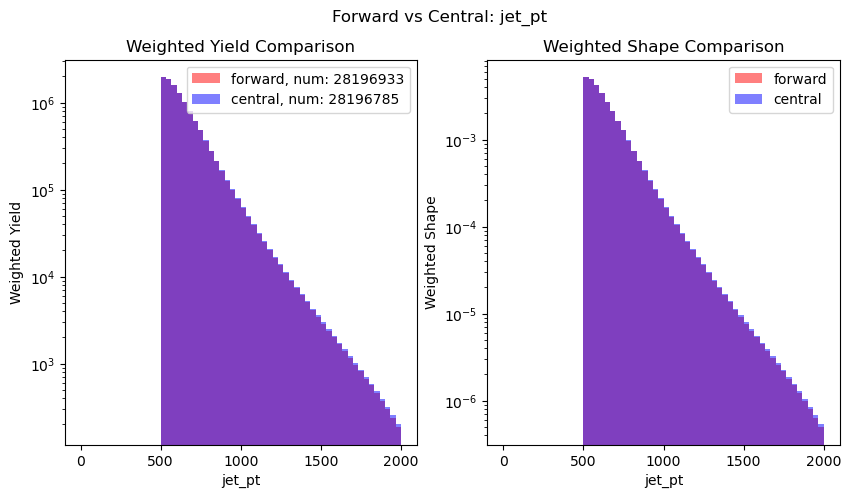

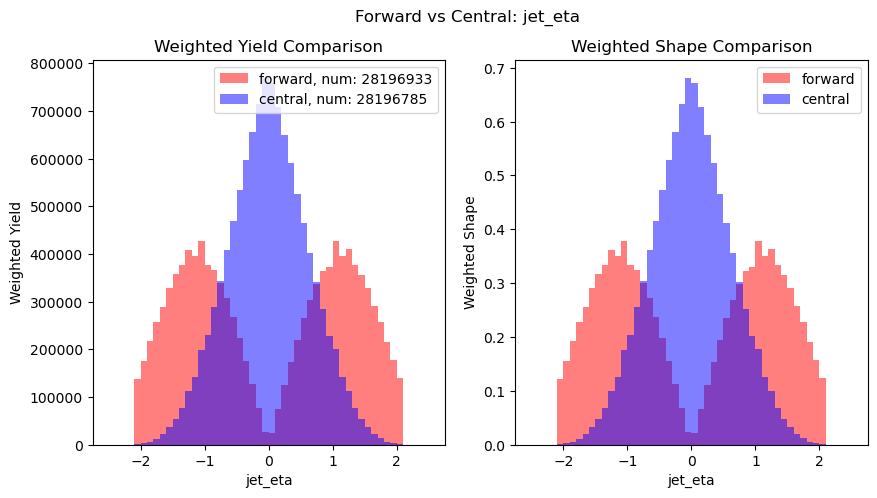

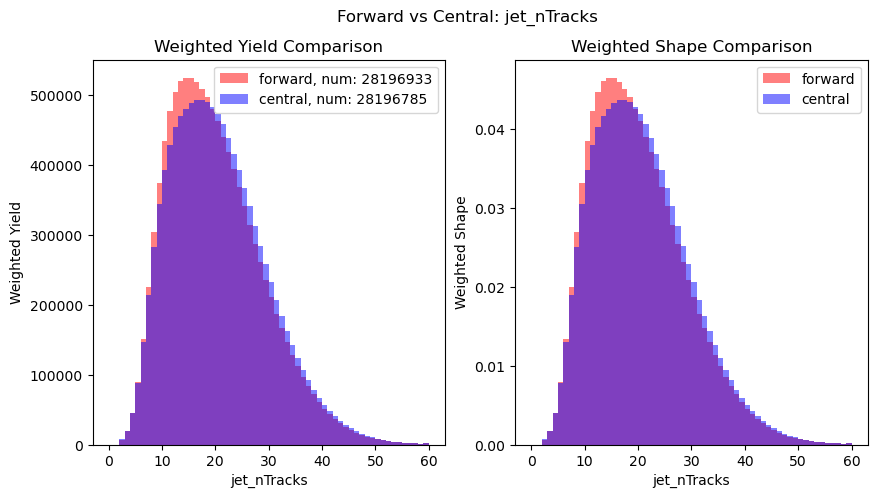

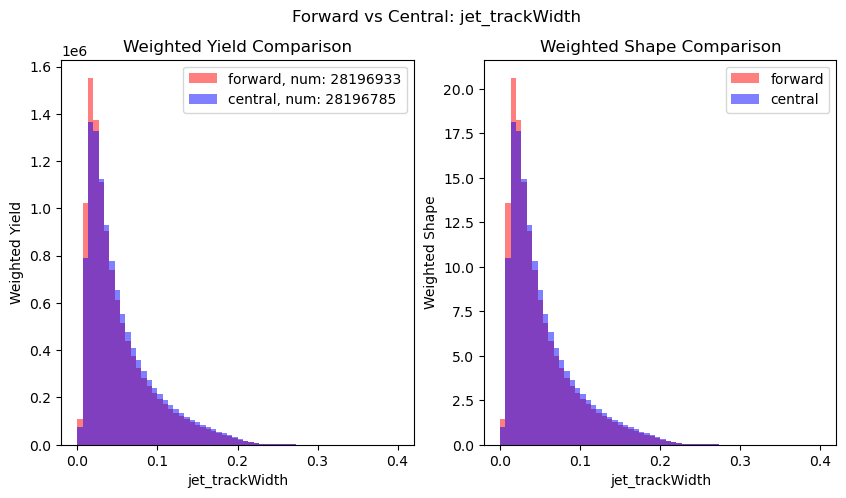

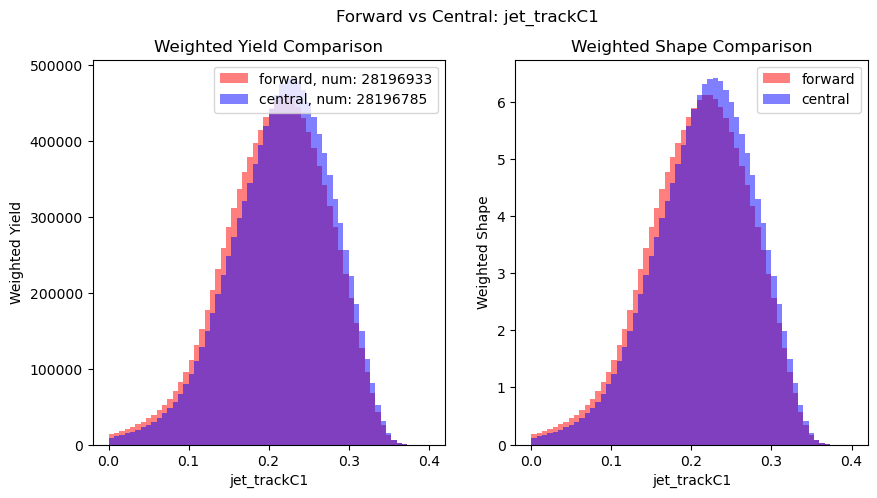

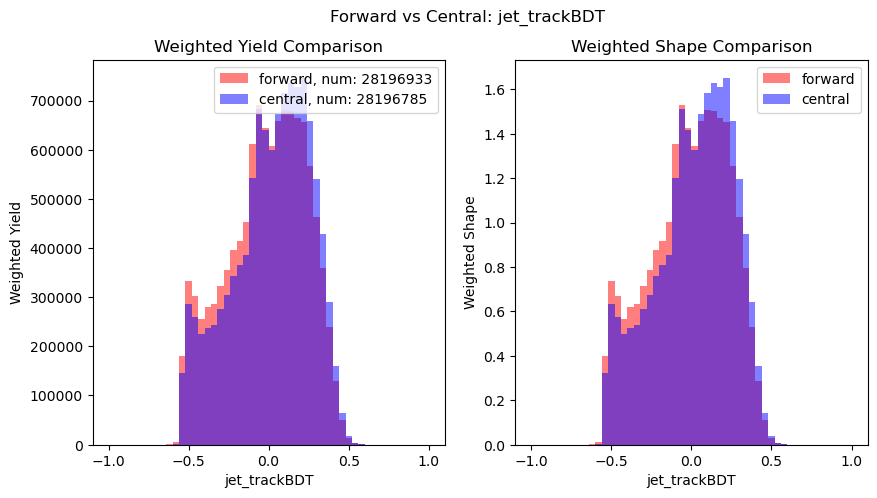

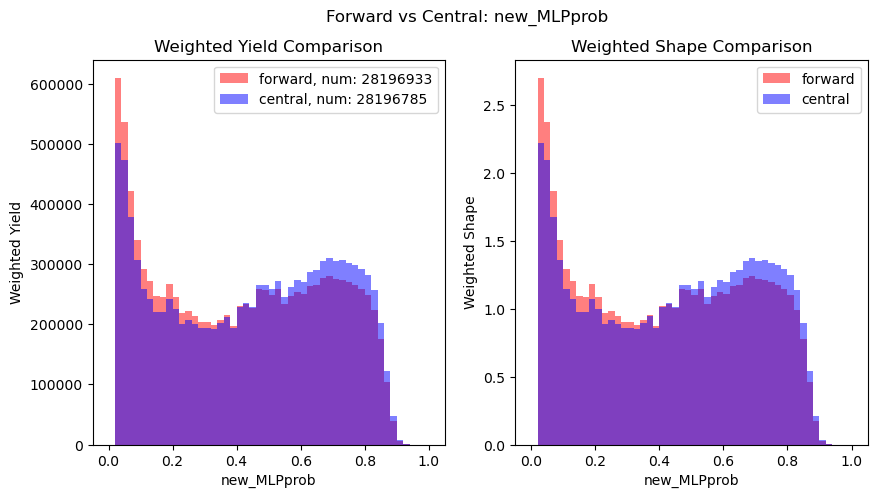

In [15]:
y_sample = clf.predict_proba(scaler.transform(sample[training_vars]))[:,1]
sample['new_MLPprob'] = y_sample

features = [*sample.columns[:6]] + ['new_MLPprob'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(0.0, 1.0, 51),
}

sample_forward = sample[sample['is_forward']==1]
sample_central = sample[sample['is_forward']==0]

for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()
    

### test extraction

Text(0.5, 0.98, 'new_MLPprob')

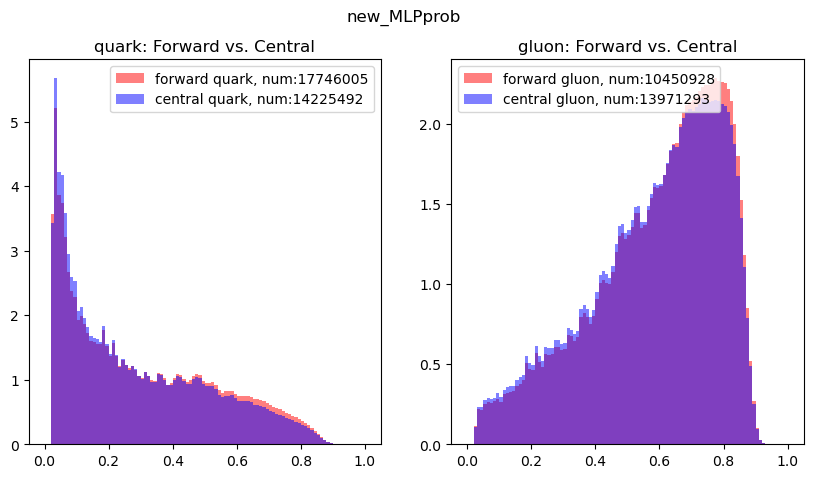

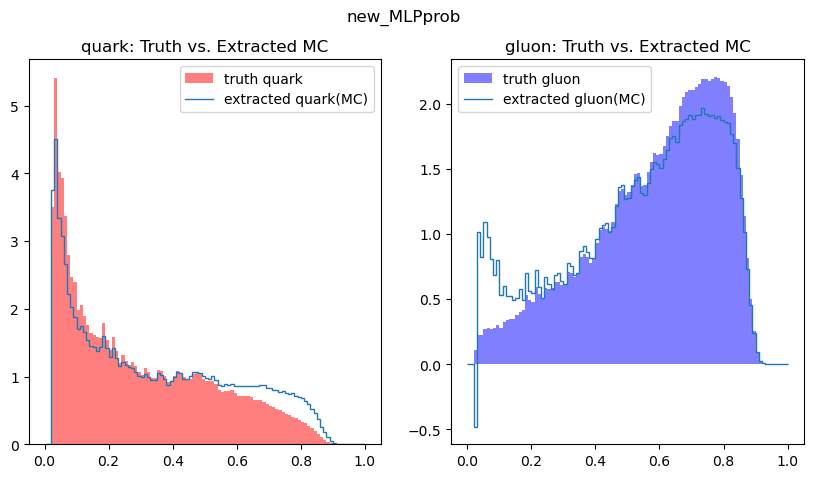

In [16]:
forward_quark = sample[(sample['is_forward']==1) &(sample['target']==0)]
forward_gluon = sample[(sample['is_forward']==1) &(sample['target']==1)]
central_quark = sample[(sample['is_forward']==0) &(sample['target']==0)]
central_gluon = sample[(sample['is_forward']==0) &(sample['target']==1)]
forward = sample[(sample['is_forward']==1)]
central = sample[(sample['is_forward']==0)]
quark = sample[sample['target']==0]
gluon = sample[sample['target']==1]

newbdt_bins = np.linspace(0.0, 1.0, 101)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
feature = 'new_MLPprob'
ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
          label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
          label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
ax[0].legend()
ax[0].set_title('quark: Forward vs. Central')

ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
          label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
          label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
ax[1].set_title('gluon: Forward vs. Central')
ax[1].legend()
fig.suptitle(feature)




n_forward_quark = len(forward_quark)
n_central_quark = len(central_quark)
n_forward = len(forward)
n_central = len(central)

frac_forward_quark = n_forward_quark / n_forward
frac_central_quark = n_central_quark / n_central

frac_forward_gluon = 1 - frac_forward_quark
frac_central_gluon = 1 - frac_central_quark

f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
f_inv = np.linalg.inv(f)


# Do a simple extraction test
# MC closure 
feature = 'new_MLPprob'
newbdt_bins = np.linspace(0.0, 1.0, 101)
hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
          label=f'truth quark', color='red', alpha = 0.5, density=True)
ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
ax[0].legend()
ax[0].set_title('quark: Truth vs. Extracted MC')

ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
          label=f'truth gluon', color='blue', alpha = 0.5, density=True)
ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
ax[1].legend()
ax[1].set_title('gluon: Truth vs. Extracted MC')

fig.suptitle(feature)


## pt bins 

### MLPprob distribution

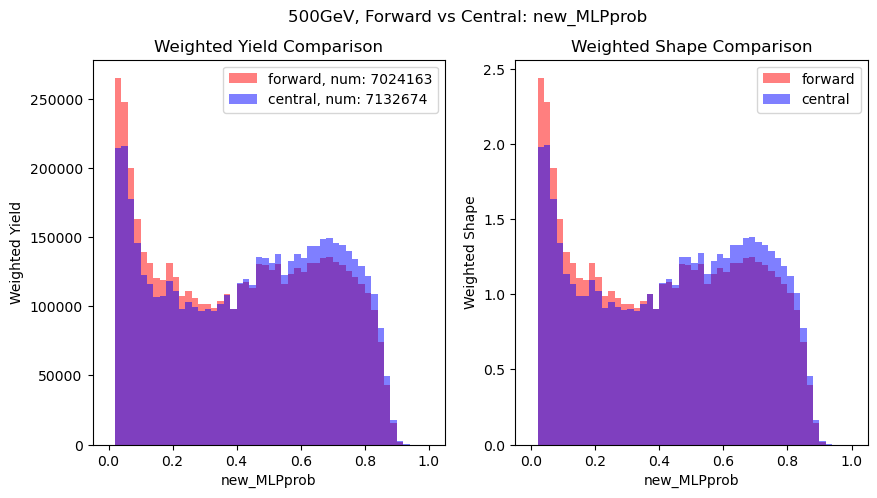

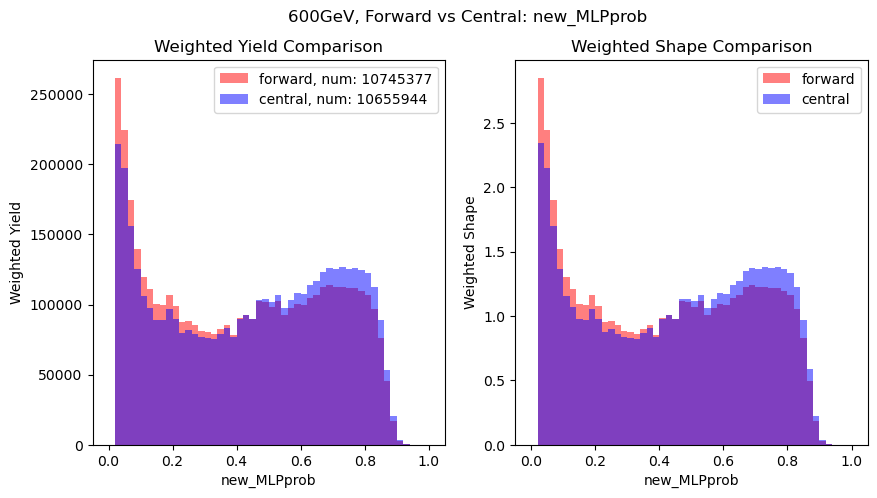

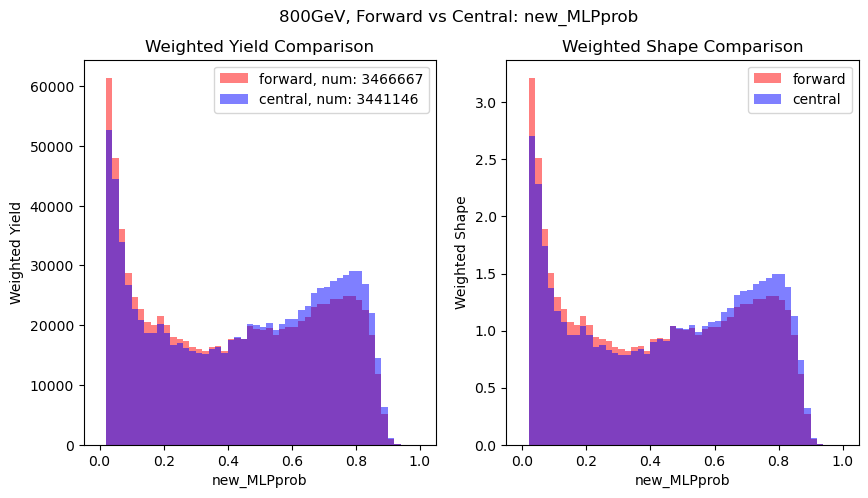

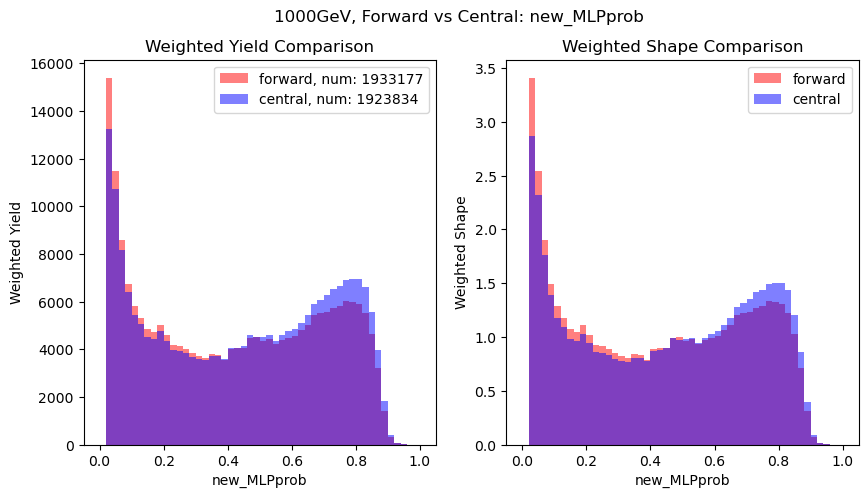

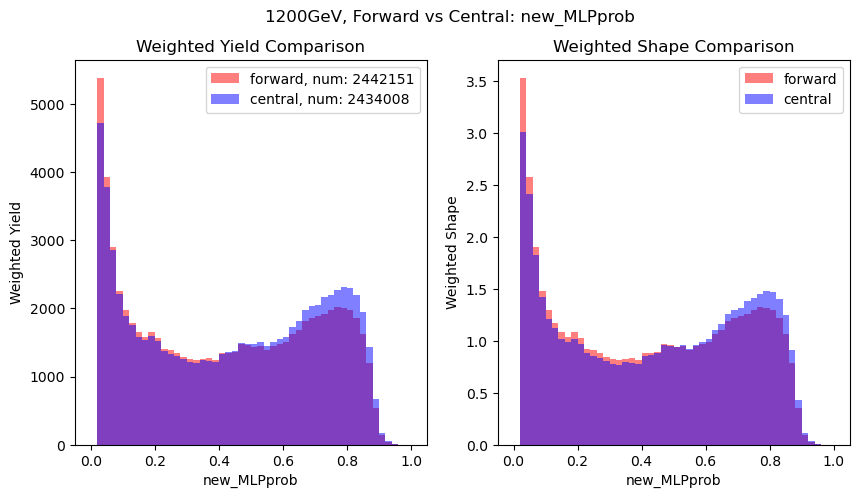

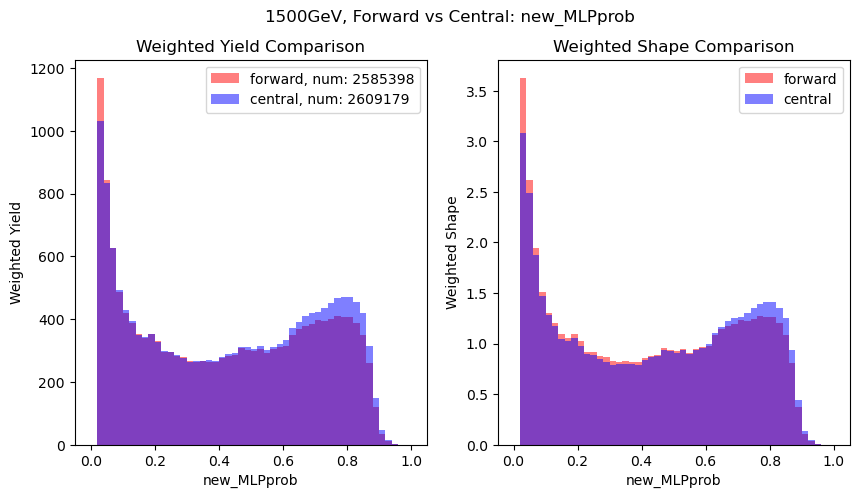

In [17]:
for pt_idx, pt in enumerate(label_pt_bin[:-1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx] 

    sample_forward = sample_pt[sample_pt['is_forward']==1]
    sample_central = sample_pt[sample_pt['is_forward']==0]

    for feature_name in features[-1:]:
        custom_bins = HistBins[feature_name]
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
        ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
        ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
        ax0.legend()
        ax0.set_xlabel(feature_name)
        ax0.set_ylabel(f"Weighted Yield")
        ax0.set_title(f"Weighted Yield Comparison")
        if feature_name == 'jet_pt':
            ax0.set_yscale('log')

        ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
        ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
        ax1.legend()
        ax1.set_xlabel(feature_name)
        ax1.set_ylabel(f"Weighted Shape")
        ax1.set_title(f"Weighted Shape Comparison")
        if feature_name == 'jet_pt':
            ax1.set_yscale('log')
        fig.suptitle(f"{pt}GeV, Forward vs Central: {feature_name}")
        plt.plot()
    

### test extraction

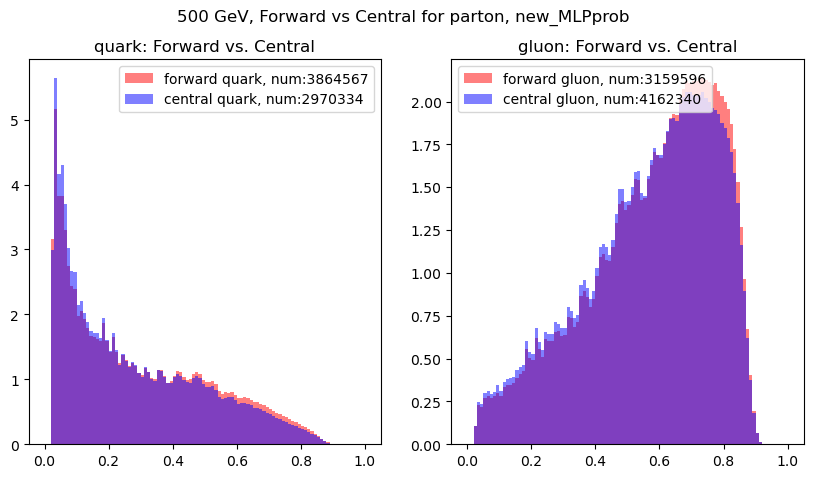

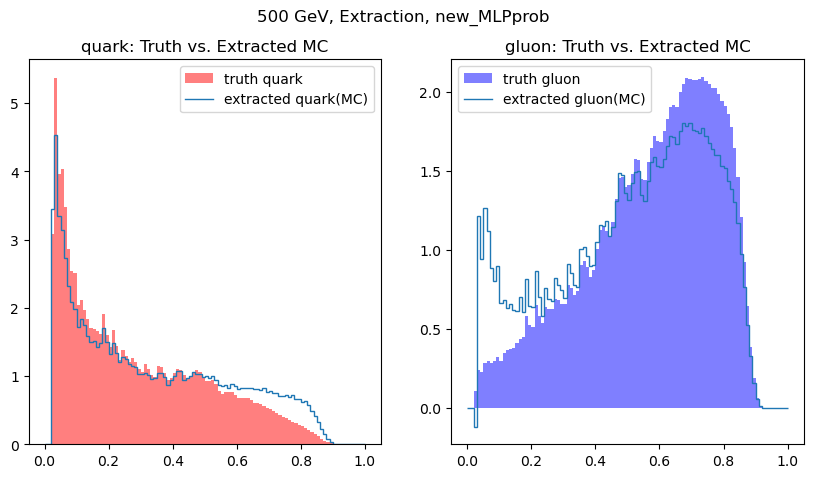

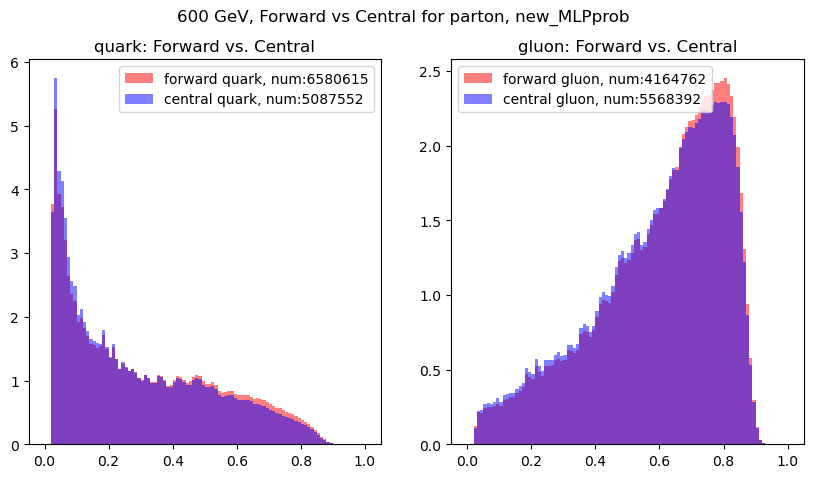

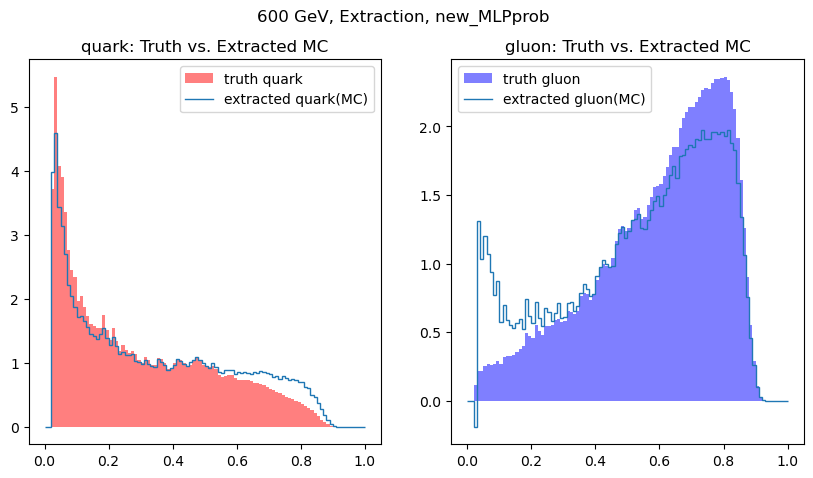

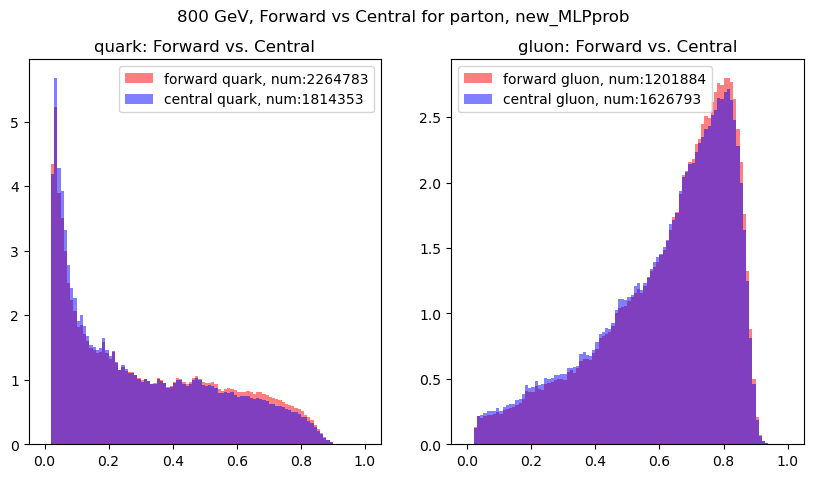

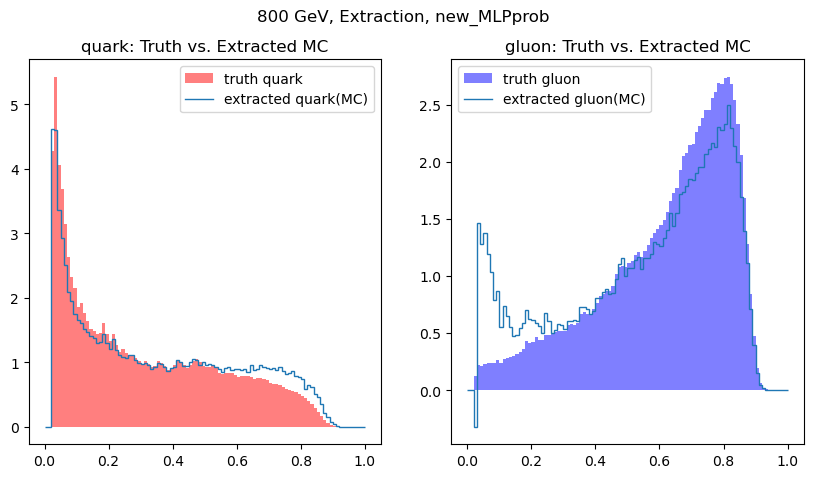

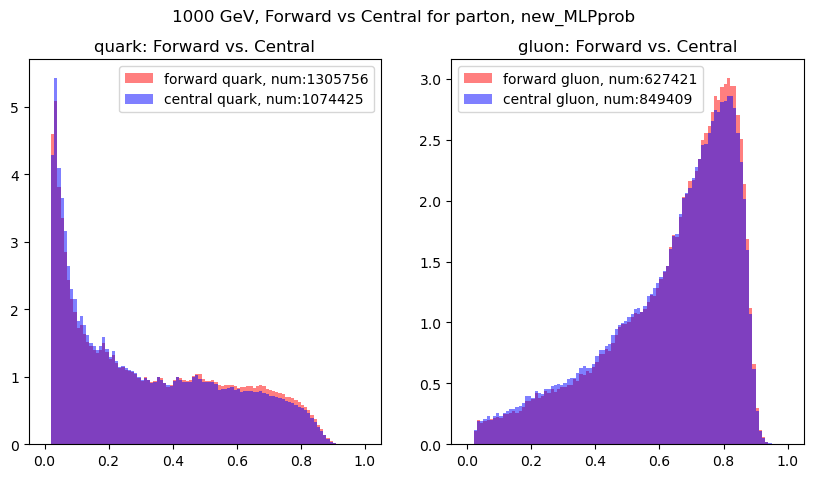

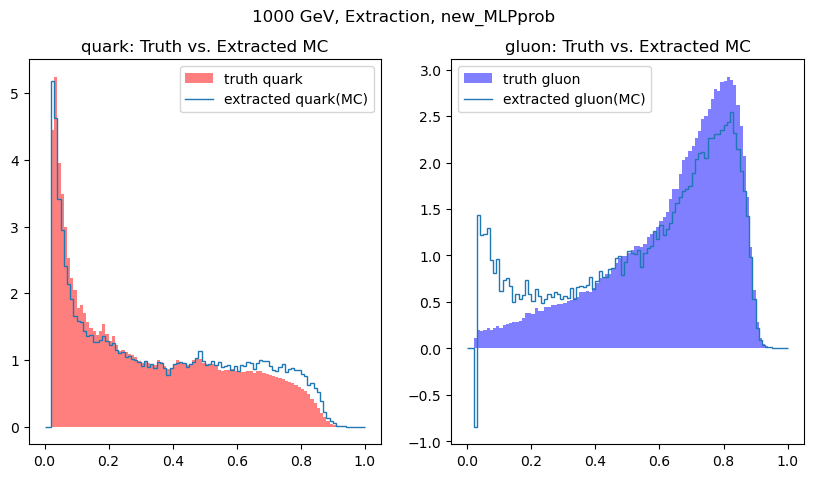

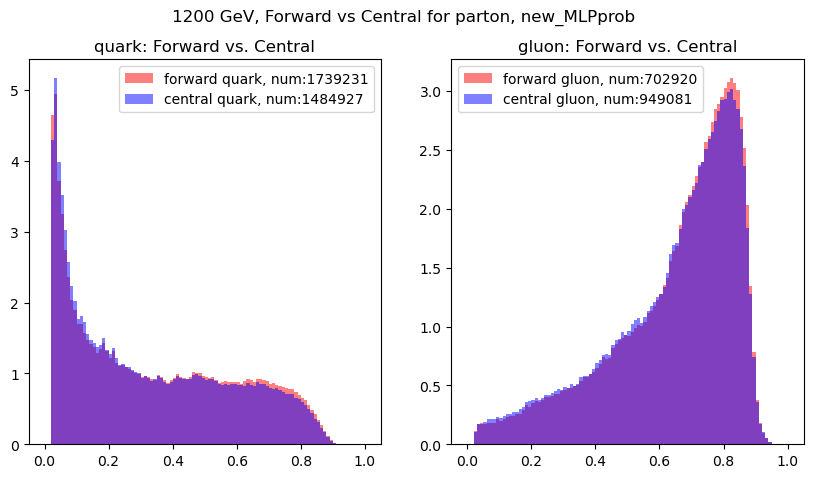

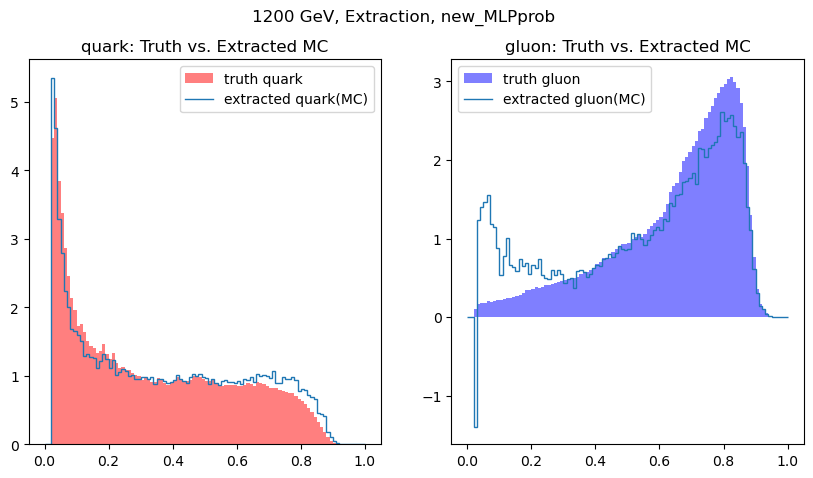

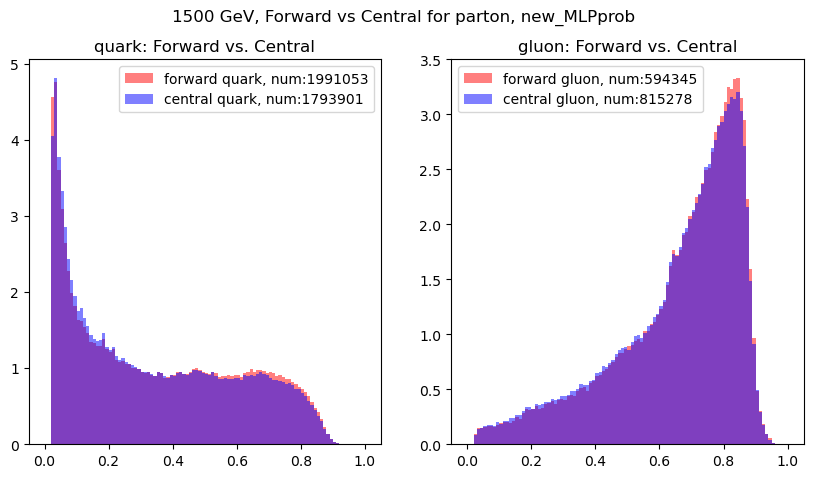

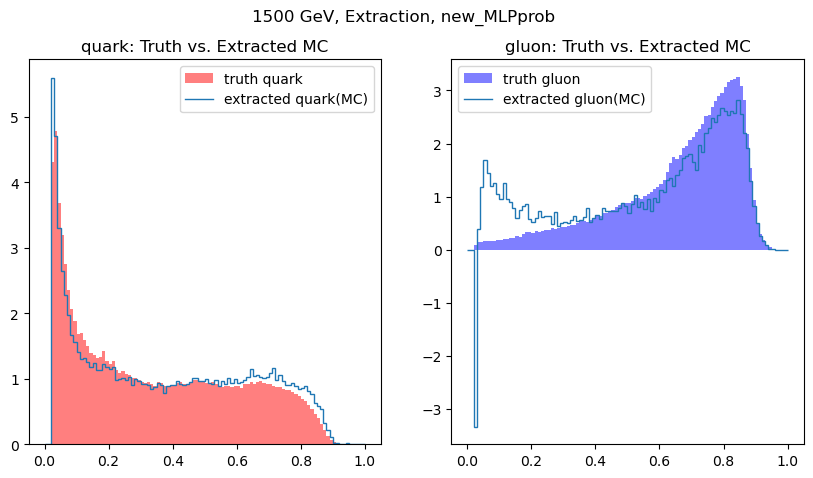

In [18]:
for pt_idx, pt in enumerate(label_pt_bin[:-1]):
    sample_pt = sample[sample['pt_idx'] == pt_idx] 
    _sample = sample_pt
    forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
    forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
    central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
    central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]
    forward = _sample[(_sample['is_forward']==1)]
    central = _sample[(_sample['is_forward']==0)]
    quark = _sample[_sample['target']==0]
    gluon = _sample[_sample['target']==1]

    newbdt_bins = np.linspace(0.0, 1.0, 101)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    feature = 'new_MLPprob'
    ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
            label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
    ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
            label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
    ax[0].legend()
    ax[0].set_title('quark: Forward vs. Central')

    ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
            label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
    ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
            label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
    ax[1].set_title('gluon: Forward vs. Central')
    ax[1].legend()
    fig.suptitle(f"{pt} GeV, Forward vs Central for parton, {feature}")




    n_forward_quark = len(forward_quark)
    n_central_quark = len(central_quark)
    n_forward = len(forward)
    n_central = len(central)

    frac_forward_quark = n_forward_quark / n_forward
    frac_central_quark = n_central_quark / n_central

    frac_forward_gluon = 1 - frac_forward_quark
    frac_central_gluon = 1 - frac_central_quark

    f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
    f_inv = np.linalg.inv(f)


    # Do a simple extraction test
    # MC closure 
    feature = 'new_MLPprob'
    newbdt_bins = np.linspace(0.0, 1.0, 101)
    hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
    hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


    extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
    extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
            label=f'truth quark', color='red', alpha = 0.5, density=True)
    ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
    ax[0].legend()
    ax[0].set_title('quark: Truth vs. Extracted MC')

    ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
            label=f'truth gluon', color='blue', alpha = 0.5, density=True)
    ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
    ax[1].legend()
    ax[1].set_title('gluon: Truth vs. Extracted MC')

    fig.suptitle(f"{pt} GeV, Extraction, {feature}")